# Objective
We have to predict the word or phrase that exemplifies the provided sentiment. 

Format:
`<id> "word or phrase that supports the sentiment"`

Examples:

*2, "very good"*

*6, "bad"*



# Similarity score 
The metrics used in this competition is a word level **Jaccard score**. It is a measure of how similar/dissimilar the two sets of sentences are.

Implementation of Jaccard score in Python:

In [1]:
def jaccard_score(x, y):
    z = x.intersection(y)
    return float(len(z)) / (len(x) + len(y) - len(z))

sentence_1 = "My name is Ankit Sharma"
sentence_2 = "I am Ankit"

s1 = set(sentence_1.lower().split())
s2 = set(sentence_2.lower().split())

print(jaccard_score(s1, s2))

0.14285714285714285


# Importing libraries

In [2]:
# Importing important libraris
import pandas as pd
import numpy as np


# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# for plotting graphs and visualization
from plotly.offline import iplot
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')


# File system manangement
import os

from wordcloud import WordCloud

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Pytorch
import torch
import torch.nn as nn

from tqdm import tqdm
import string

#Transformers
import transformers
import tokenizers
from transformers import BertTokenizer, BertModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



# General EDA

In [3]:
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv')

print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

Training data shape: (27481, 4)
Test data shape: (3534, 3)


In [4]:
# Checking the first few rows
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


The columns:

- `textID`: Text ID of the tweet
- `text`: Text of the tweet
- `selected_text`: Polarity of the tweet
- `sentiment`: Sentiment of the tweet

## Missing values
Checking if there are missing values in the data. 

In [6]:
train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [7]:
test.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

The column `text` and `selected_text` has one missing row from the dataset. Since, the missing data is minimal we can get rid of them. 

In [8]:
# dropping the missing values
train.dropna(axis=0, how='any', inplace=True)

## Analysing the sentiment column

Analyzing and seeing the `sentiment column` for the train and test data

### Different types of sentiment
- positive
- negative
- neutral

In [9]:
# positive tweet
print(f"Positive tweet example: {train[train['sentiment'] == 'positive']['text'].values[0]}")

# negative tweet
print(f"Negative tweet example: {train[train['sentiment'] == 'negative']['text'].values[0]}")

# neutral tweet
print(f"Neutral tweet example: {train[train['sentiment'] == 'neutral']['text'].values[0]}")

Positive tweet example: 2am feedings for the baby are fun when he is all smiles and coos
Negative tweet example:  Sooo SAD I will miss you here in San Diego!!!
Neutral tweet example:  I`d have responded, if I were going


### Distribution of sentiment in train and test data

Distribution in both number and percentages

In [10]:
train['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [11]:
test['sentiment'].value_counts()

neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64

In [12]:
print(f"Train sentiment: \n{(train['sentiment'].value_counts(normalize=True)) * 100}")
print(f"\n")
print(f"Test sentiment: \n{(test['sentiment'].value_counts(normalize=True)) * 100}")

Train sentiment: 
neutral     40.454876
positive    31.229985
negative    28.315138
Name: sentiment, dtype: float64


Test sentiment: 
neutral     40.464063
positive    31.211092
negative    28.324844
Name: sentiment, dtype: float64


About 40 percent tweets are neutral, followed by 31 percent being positive and 28 percent being negative. The distribution is similar for both `train` and `test` data.

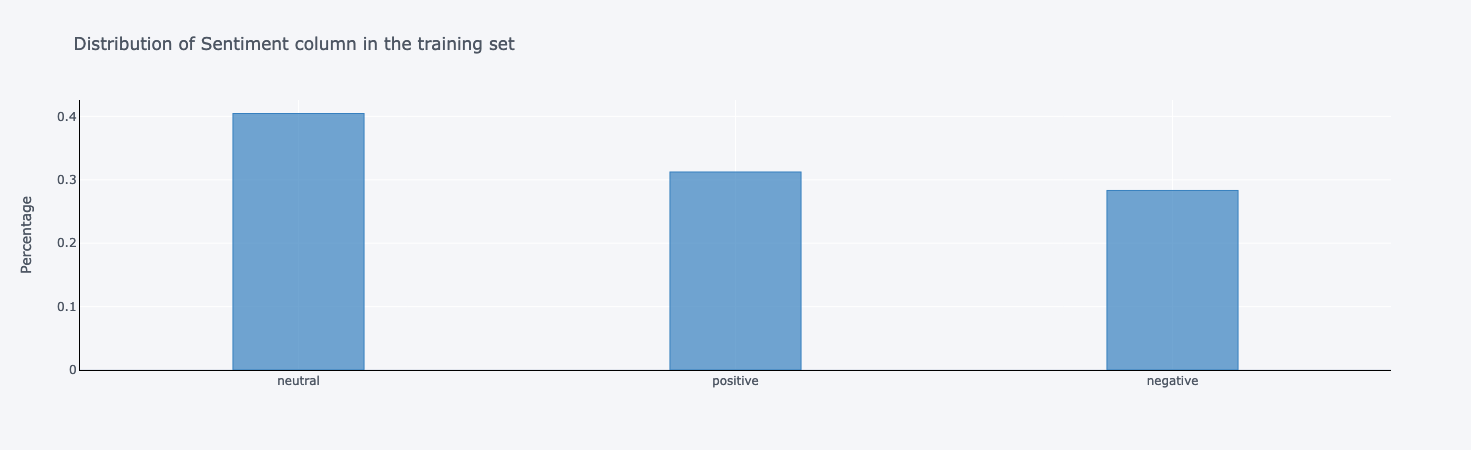

In [13]:
train['sentiment'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='blue',
                                                      theme='pearl',
                                                      bargap=0.7,
                                                      gridcolor='white',
                                                     
                                                      title='Distribution of Sentiment column in the training set')

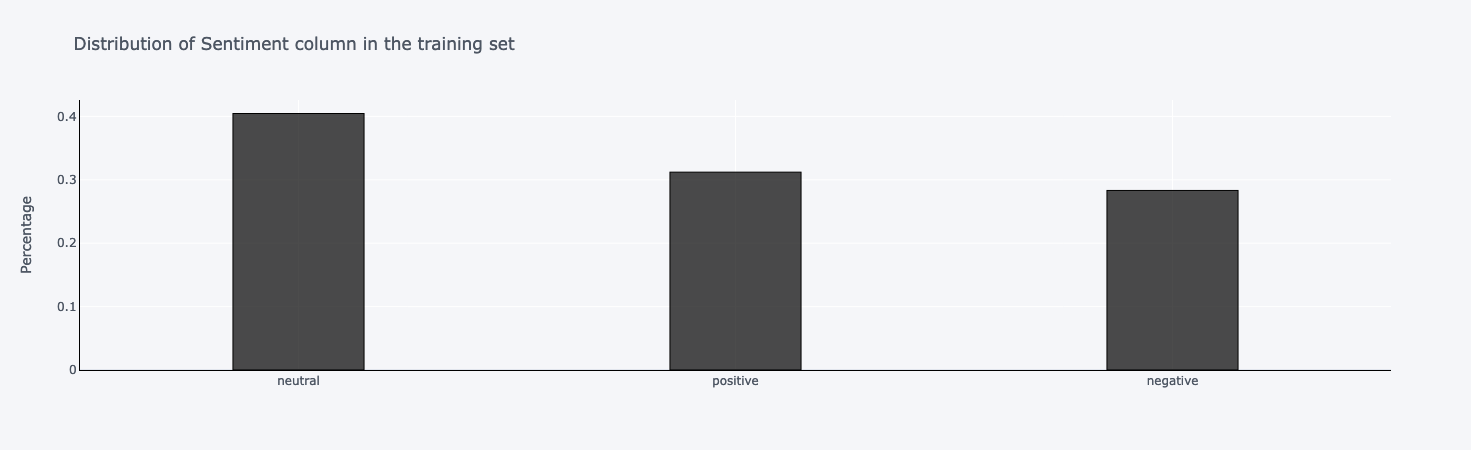

In [14]:
test['sentiment'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='black',
                                                      theme='pearl',
                                                      bargap=0.7,
                                                      gridcolor='white',
                                                     
                                                      title='Distribution of Sentiment column in the training set')

# Text Data Processing 

We will pre-process our data to make it into consistent format. 

- Make texts lowercase
- Remove hyperlinks and punctuations
- Remover numbers
- Tokenizes
- Remove stopwords

`clean_text()` and `text_preprocessing` are two function which we are going to use. 
- `clean_text()` helps in making the texts lowercase, removing hyperlinks and punctuations, remove words containing numbers
- `text_preprocessing()` helps in tokenizing and removing stopwords 

In [15]:
def clean_text(text):
    """
    Removes:
        - Texts in square brackets
        - Links
        - Punctuations
        - Words containing numbers

    Makes texts lowercase
    """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [16]:
def text_preprocessing(text):
    """
    - Tokenizes
    - Remove stopwords 
    - Clean text
    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    no_punctuation = clean_text(text)
    
    tokenized_text = tokenizer.tokenize(no_punctuation)
    remove_stopwords = [word for word in tokenized_text if word not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    
    return combined_text

In [17]:
train['clean_text'] = train['text'].apply(str).apply(lambda x : text_preprocessing(x))

train.head()

,textID,text,selected_text,sentiment,clean_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,boss bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,interview leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons couldnt put releases already bought


In [18]:
# Similarly, for test data
test['clean_text'] = test['text'].apply(str).apply(lambda x : text_preprocessing(x))

test.head()

,textID,text,sentiment,clean_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session day
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,shanghai also really exciting precisely skyscr...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho quit compan...
3,01082688c6,happy bday!,positive,happy bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,like


# Text Statistics
We will analyze our texts:
- Text length analysis
- Word frequency analysis

Adding `text_length` and `text_word_count` columns for our analysis

In [19]:
train['text_length'] = train['clean_text'].astype(str).apply(len) # counts the spaces as well

In [20]:
train['text_word_count'] = train['clean_text'].apply(lambda x : len(str(x).split()))

In [21]:
train.head()

,textID,text,selected_text,sentiment,clean_text,text_length,text_word_count
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id responded going,18,3
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego,23,5
2,088c60f138,my boss is bullying me...,bullying me,negative,boss bullying,13,2
3,9642c003ef,what interview! leave me alone,leave me alone,negative,interview leave alone,21,3
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons couldnt put releases already bought,40,6


Create 3 different DataFrame for:
- positive 
- negative
- neutral

In [22]:
# 3 different dataframes for our sentiment
positive = train[train['sentiment'] == 'positive']
negative = train[train['sentiment'] == 'negative']
neutral = train[train['sentiment'] == 'neutral']

In [23]:
positive.head()

,textID,text,selected_text,sentiment,clean_text,text_length,text_word_count
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,feedings baby fun smiles coos,29,5
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,journey wow u became cooler hehe possible,41,7
11,16fab9f95b,I really really like the song Love Story by Ta...,like,positive,really really like song love story taylor swift,47,8
21,e48b0b8a23,Playing Ghost Online is really interesting. Th...,interesting.,positive,playing ghost online really interesting new up...,102,16
25,e00c6ef376,"the free fillin` app on my ipod is fun, im add...","the free fillin` app on my ipod is fun, im add...",positive,free fillin app ipod fun im addicted,36,7


## Sentence length analysis

The histogram shows that the length of the cleaned text ranges from around 2 to 140 characters and generally,it is almost same for all the polarities.

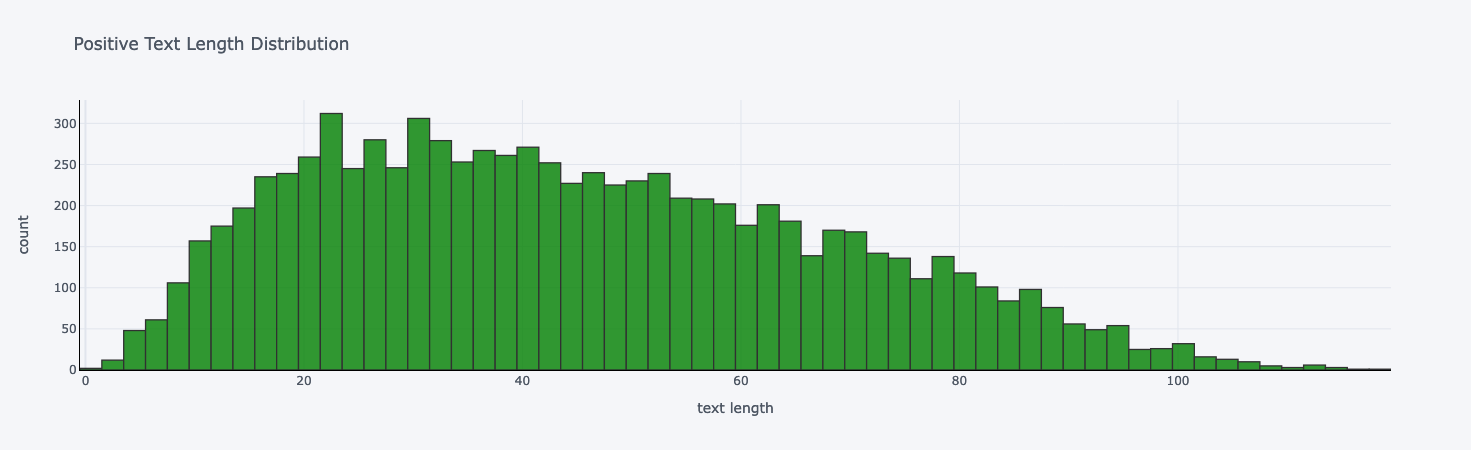

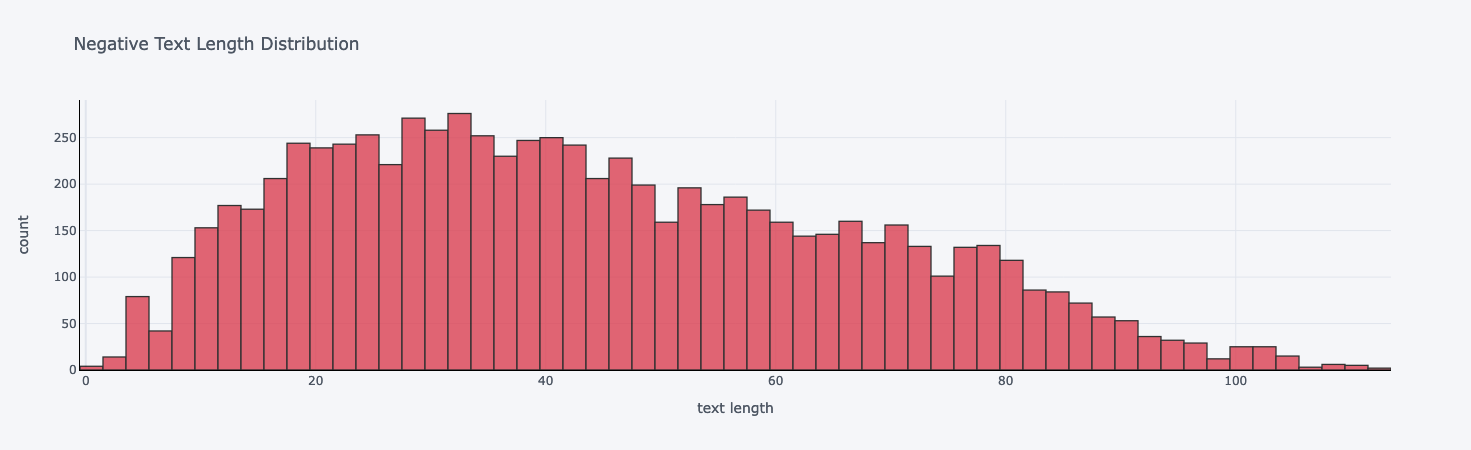

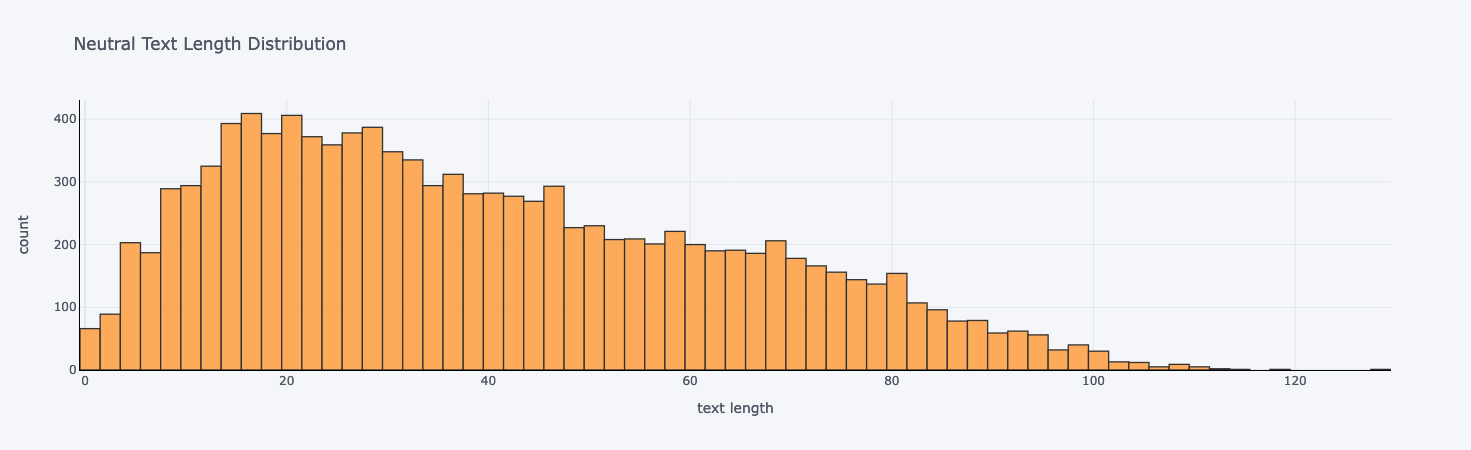

In [24]:
positive['text_length'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='Positive Text Length Distribution')

negative['text_length'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Negative Text Length Distribution')

neutral['text_length'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='Neutral Text Length Distribution')

Relationship of text length with the sentiment

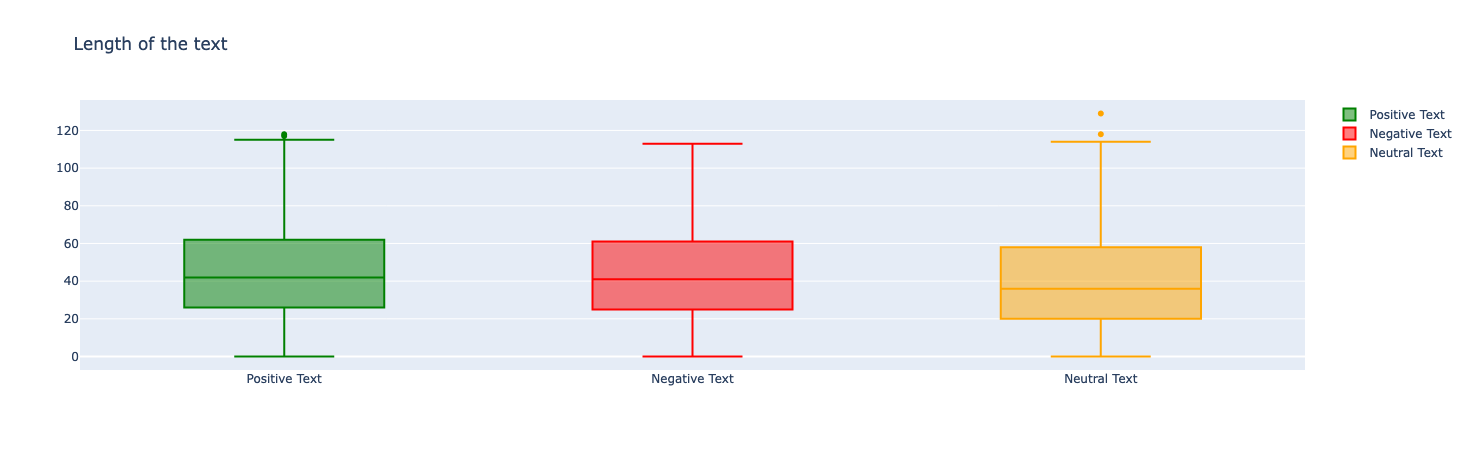

In [25]:
trace0 = go.Box(
    y=positive['text_length'],
    name = 'Positive Text',
    marker = dict(
        color = 'green',
    )
)

trace1 = go.Box(
    y=negative['text_length'],
    name = 'Negative Text',
    marker = dict(
        color = 'red',
    )
)

trace2 = go.Box(
    y=neutral['text_length'],
    name = 'Neutral Text',
    marker = dict(
        color = 'orange',
    )
)
data = [trace0, trace1, trace2]
layout = go.Layout(
    title = "Length of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Length of the text of different polarities")

# Ngram exploration


N-grams are used to describe the number of words used as observation points
- unigram means singly-worded
- bigram means 2-worded phrase
- trigram means 3-worded phrase

![N-gram](https://i.stack.imgur.com/8ARA1.png)

In [26]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## Top unigrams

In [27]:
positive_unigrams = get_top_n_words(positive['clean_text'], 20)
positive_unigrams

[('day', 1223),
 ('good', 1046),
 ('love', 875),
 ('happy', 840),
 ('im', 740),
 ('mothers', 627),
 ('thanks', 553),
 ('great', 478),
 ('like', 413),
 ('hope', 396),
 ('fun', 344),
 ('today', 342),
 ('lol', 338),
 ('nice', 334),
 ('night', 319),
 ('really', 307),
 ('got', 302),
 ('morning', 288),
 ('time', 287),
 ('going', 283)]

In [28]:
negative_unigrams = get_top_n_words(negative['clean_text'], 20)
neutral_unigrams = get_top_n_words(neutral['clean_text'], 20)

In [29]:
neutral_unigrams

[('im', 1054),
 ('day', 503),
 ('dont', 491),
 ('going', 479),
 ('work', 477),
 ('like', 457),
 ('lol', 454),
 ('got', 453),
 ('today', 435),
 ('time', 425),
 ('know', 415),
 ('home', 336),
 ('want', 325),
 ('new', 320),
 ('good', 301),
 ('think', 289),
 ('night', 271),
 ('need', 266),
 ('really', 262),
 ('ill', 247)]

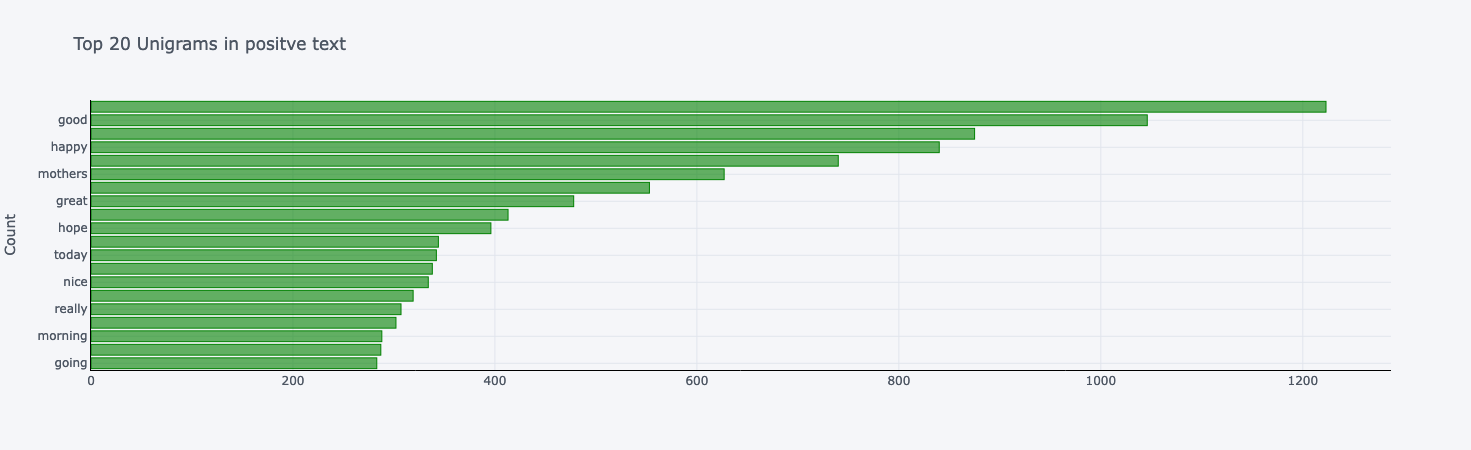

In [30]:
df1 = pd.DataFrame(positive_unigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='green', title='Top 20 Unigrams in positve text',orientation='h')

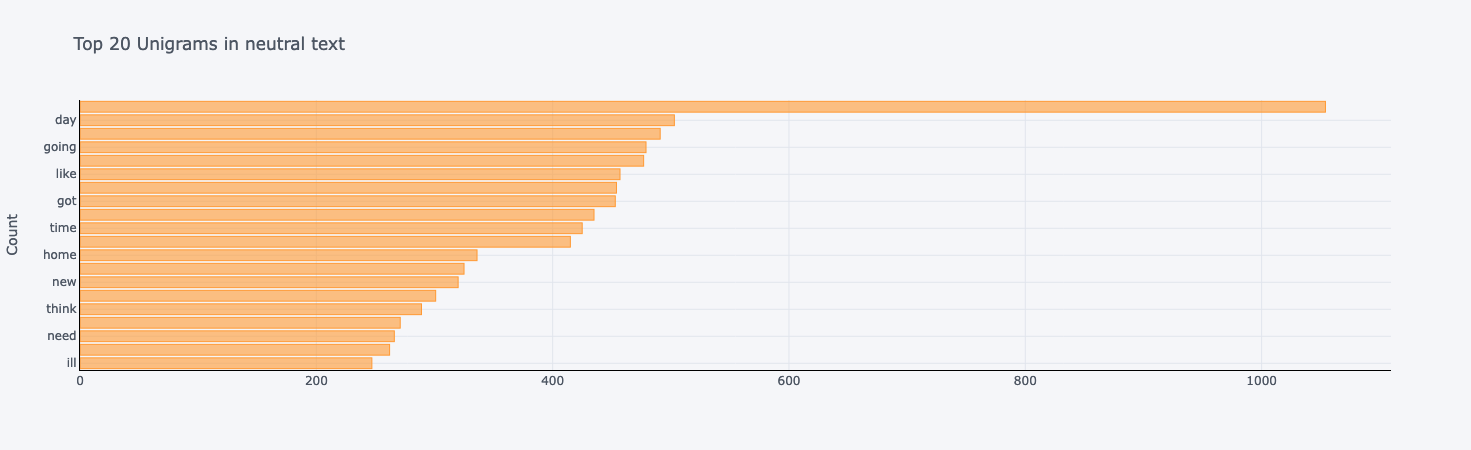

In [31]:
df1 = pd.DataFrame(neutral_unigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='orange', title='Top 20 Unigrams in neutral text',orientation='h')

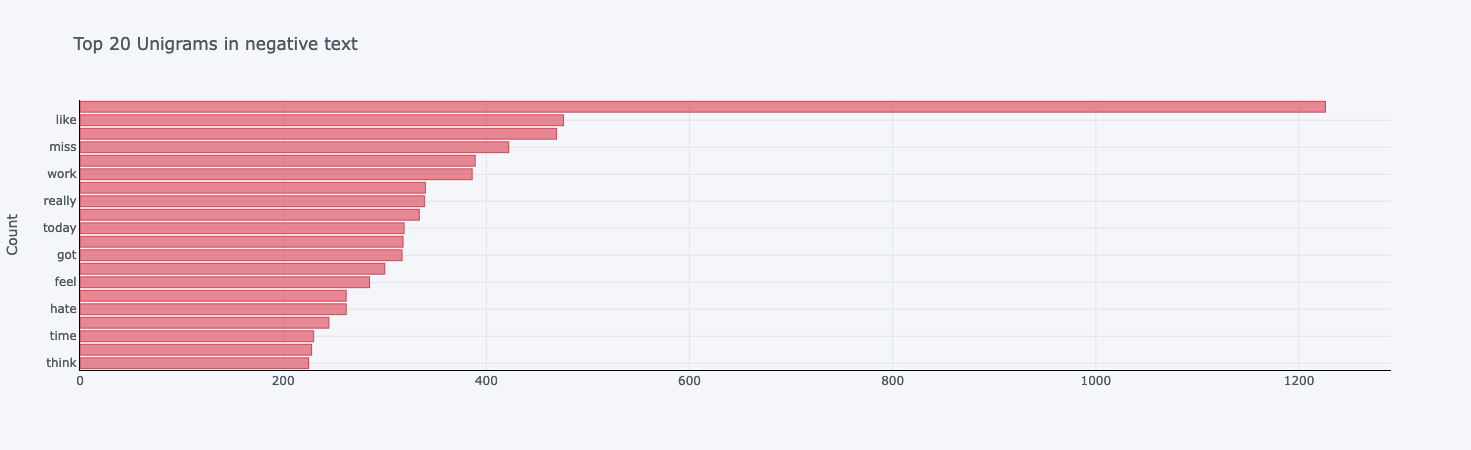

In [32]:
df1 = pd.DataFrame(negative_unigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', title='Top 20 Unigrams in negative text',orientation='h')

In [33]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [34]:
positive_bigrams = get_top_n_gram(positive['clean_text'],(2,2),20)
negative_bigrams = get_top_n_gram(negative['clean_text'],(2,2),20)
neutral_bigrams = get_top_n_gram(neutral['clean_text'],(2,2),20)

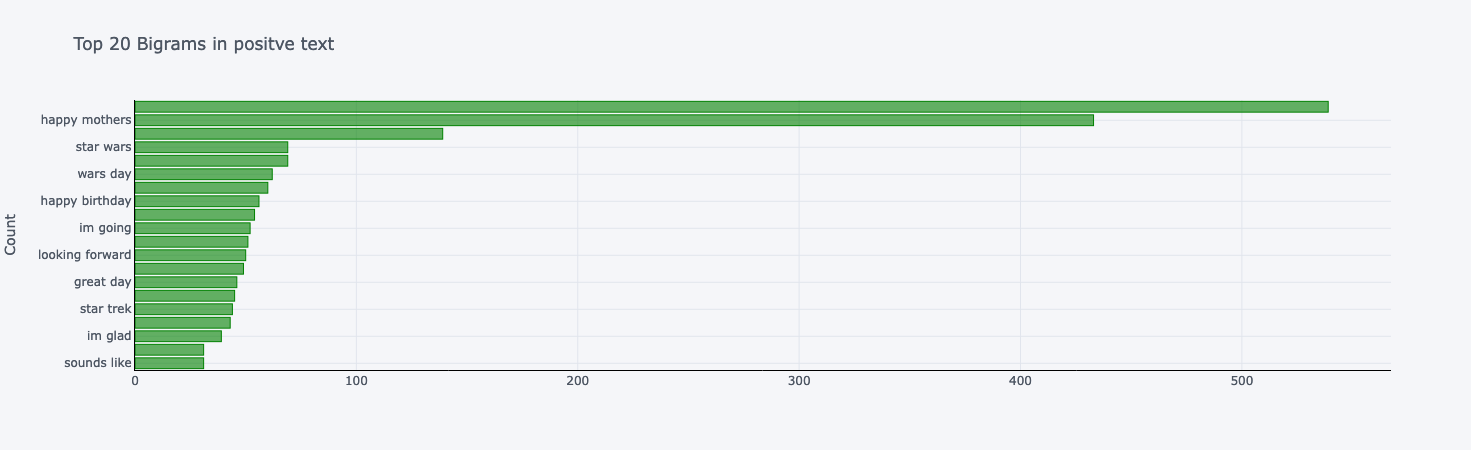

In [35]:
df1 = pd.DataFrame(positive_bigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='green', title='Top 20 Bigrams in positve text',orientation='h')

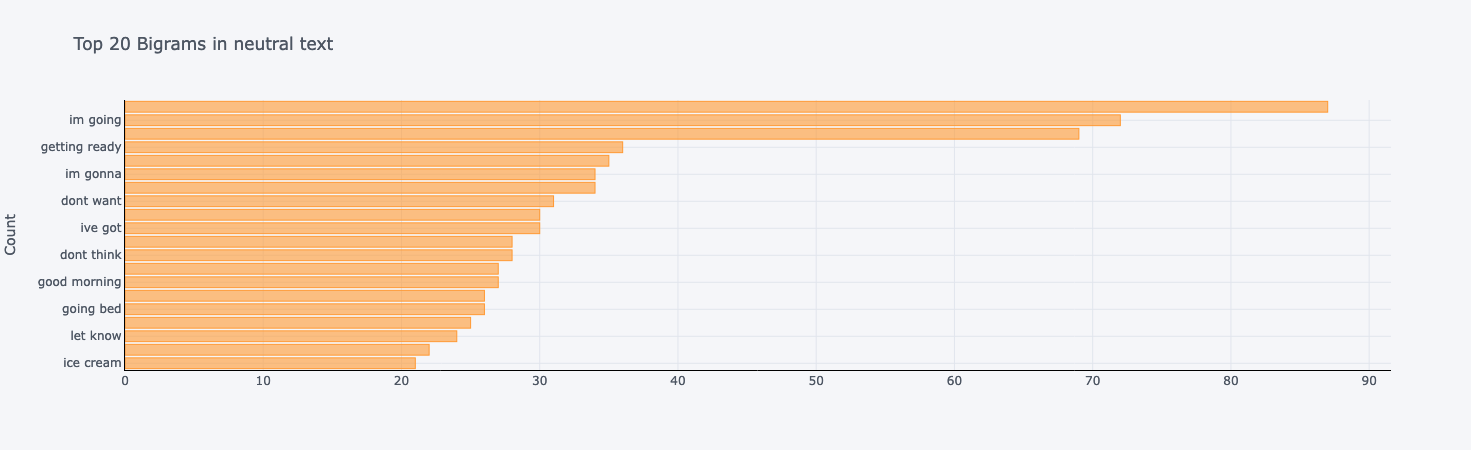

In [36]:
df1 = pd.DataFrame(neutral_bigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='orange', title='Top 20 Bigrams in neutral text',orientation='h')

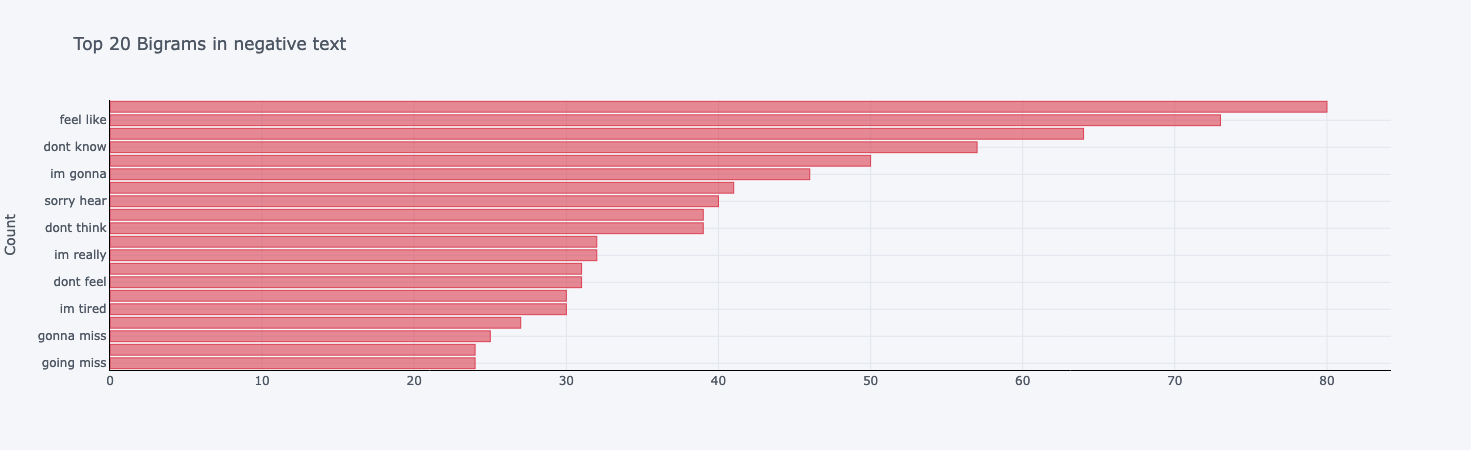

In [37]:
df1 = pd.DataFrame(negative_bigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', title='Top 20 Bigrams in negative text',orientation='h')

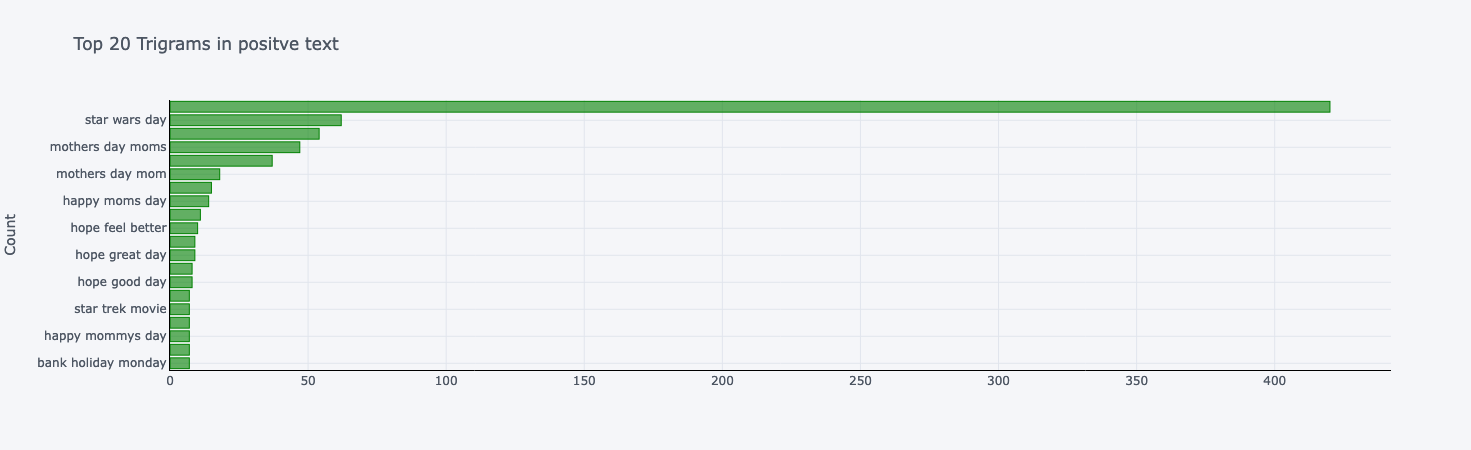

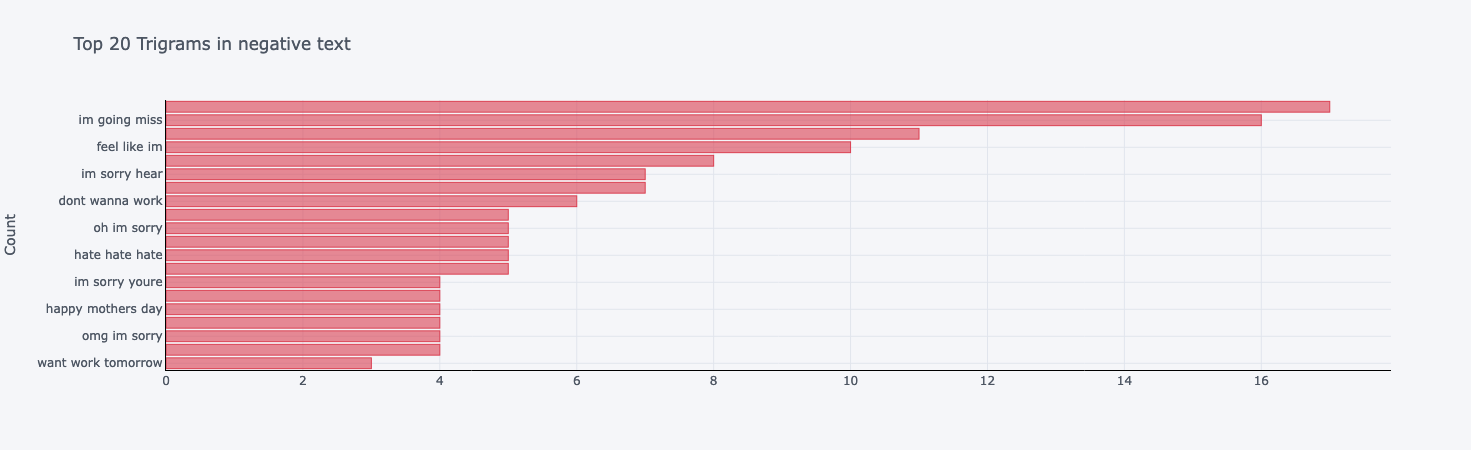

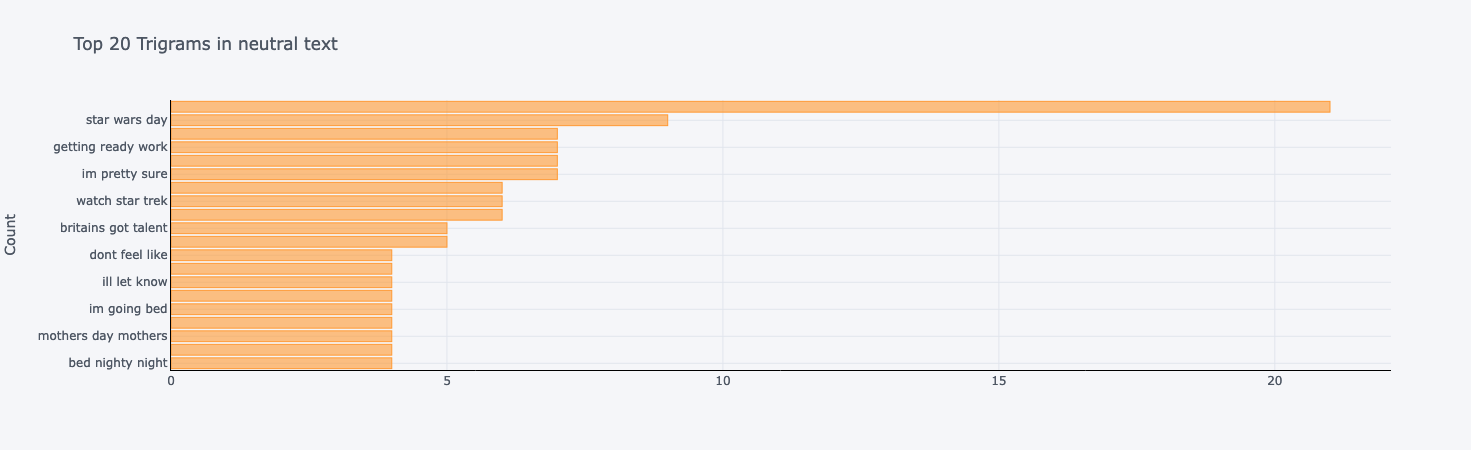

In [38]:
positive_trigrams = get_top_n_gram(positive['clean_text'],(3,3),20) 
negative_trigrams = get_top_n_gram(negative['clean_text'],(3,3),20) 
neutral_trigrams = get_top_n_gram(neutral['clean_text'],(3,3),20)

df1 = pd.DataFrame(positive_trigrams, columns = ['Text' , 'count']) 
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot( kind='bar', yTitle='Count', linecolor='black',color='green', title='Top 20 Trigrams in positve text',orientation='h')

df2 = pd.DataFrame(negative_trigrams, columns = ['Text' , 'count']) 
df2.groupby('Text').sum()['count'].sort_values(ascending=True).iplot( kind='bar', yTitle='Count', linecolor='black', color='red',title='Top 20 Trigrams in negative text',orientation='h')

df3 = pd.DataFrame(neutral_trigrams, columns = ['Text' , 'count'] ) 
df3.groupby('Text').sum()['count'].sort_values(ascending=True).iplot( kind='bar', yTitle='Count', linecolor='black', color='orange', title='Top 20 Trigrams in neutral text',orientation='h')

# Exploring selected_text

In [39]:
positive_text = train[train['sentiment'] == 'positive']['selected_text']
negative_text = train[train['sentiment'] == 'negative']['selected_text']
neutral_text = train[train['sentiment'] == 'neutral']['selected_text']

In [40]:
# Positive text
print("Positive Text example :",positive_text.values[0])
#negative_text
print("Negative Tweet example :",negative_text.values[0])
#neutral_text
print("Neutral tweet example  :",neutral_text.values[0])

Positive Text example : fun
Negative Tweet example : Sooo SAD
Neutral tweet example  : I`d have responded, if I were going


In [41]:
# pre-processed selected text column
positive_text_clean = positive_text.apply(lambda x: text_preprocessing(x))
negative_text_clean = negative_text.apply(lambda x: text_preprocessing(x))
neutral_text_clean = neutral_text.apply(lambda x: text_preprocessing(x))

In [42]:
positive_text_clean

6                                         fun
9                         wow u became cooler
11                                       like
21                                interesting
25       free fillin app ipod fun im addicted
                         ...                 
27467                                 welcome
27474                            feel good ab
27475                                   enjoy
27478                                yay good
27479                                   worth
Name: selected_text, Length: 8582, dtype: object

In [43]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


top_words_in_positive_text = get_top_n_words(positive_text_clean)
top_words_in_negative_text = get_top_n_words(negative_text_clean)
top_words_in_neutral_text = get_top_n_words(neutral_text_clean)

In [44]:
p1 = [x[0] for x in top_words_in_positive_text[:20]]
p2 = [x[1] for x in top_words_in_positive_text[:20]]


n1 = [x[0] for x in top_words_in_negative_text[:20]]
n2 = [x[1] for x in top_words_in_negative_text[:20]]


m1 = [x[0] for x in top_words_in_neutral_text[:20]]
m2 = [x[1] for x in top_words_in_neutral_text[:20]]

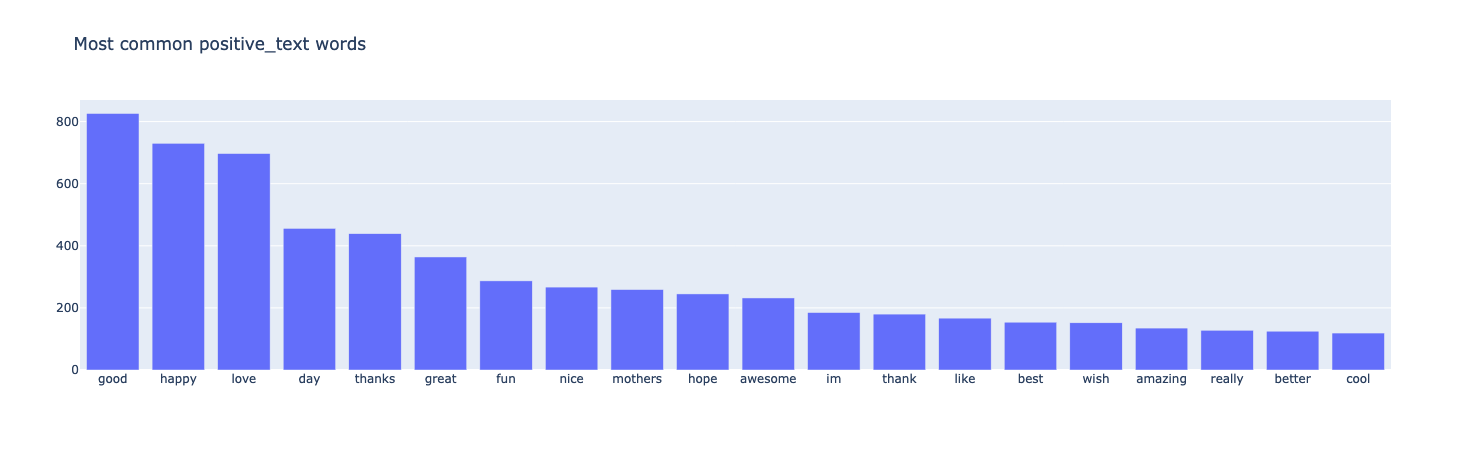

In [45]:
fig = go.Figure([go.Bar(x=p1, y=p2, text=p2 )])
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide',title_text='Most common positive_text words')
#fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')

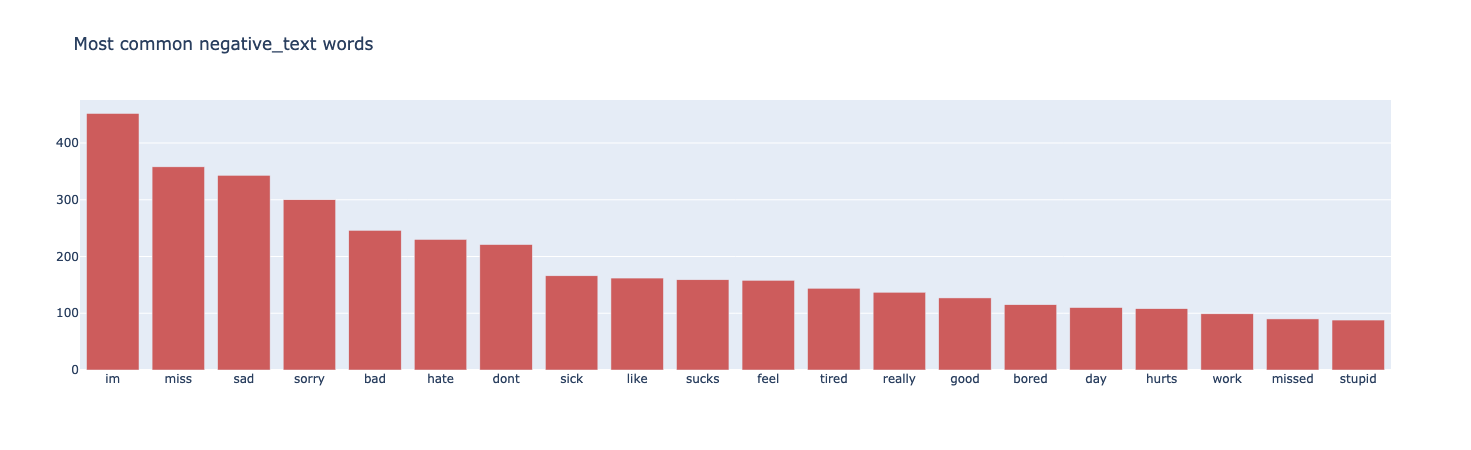

In [46]:
fig1 = go.Figure([go.Bar(x=n1, y=n2, text=n2,marker_color='indianred')])
#fig1.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig1.update_layout(uniformtext_minsize=8, uniformtext_mode='hide',title_text='Most common negative_text words')

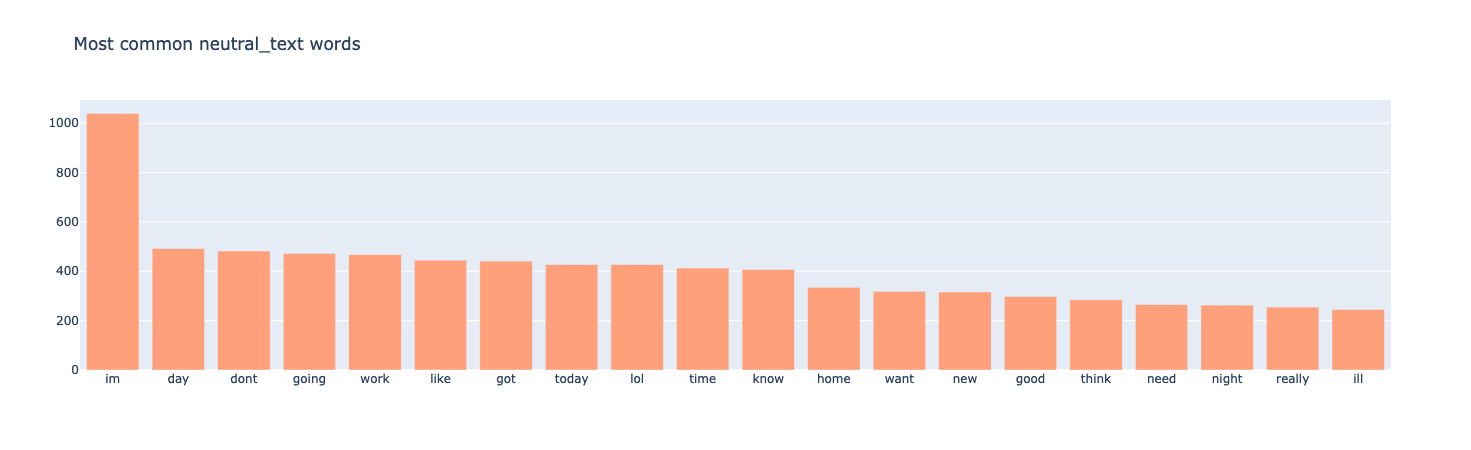

In [47]:
fig2 = go.Figure([go.Bar(x=m1, y=m2, text=m2, marker_color='lightsalmon' )])
#fig2.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig2.update_layout(uniformtext_minsize=8, uniformtext_mode='hide',title_text='Most common neutral_text words')

# Wordcloud

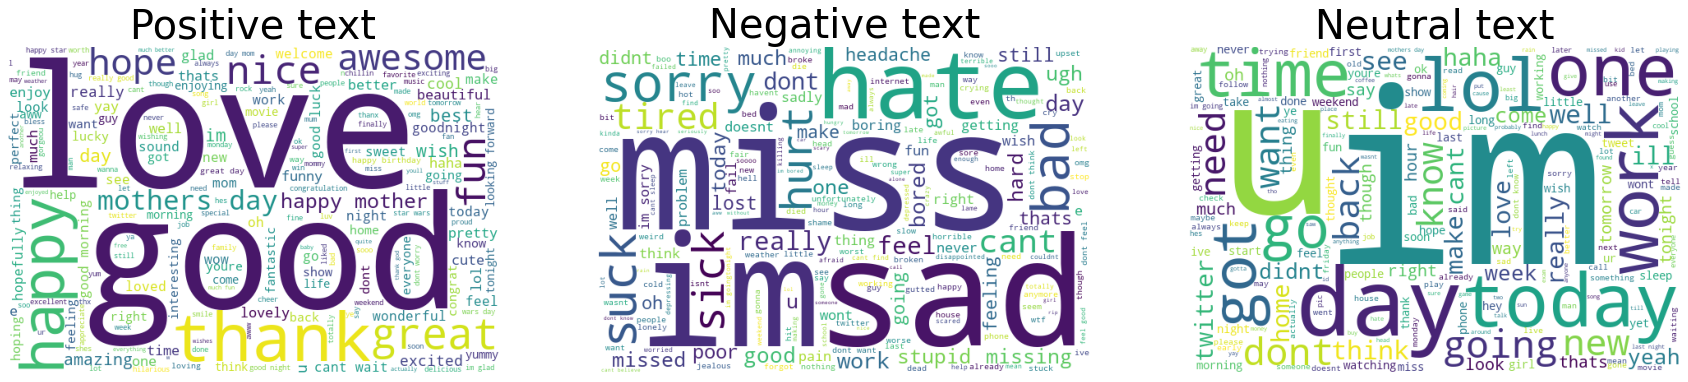

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_text_clean))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive text',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_text_clean))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative text',fontsize=40);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neutral_text_clean))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral text',fontsize=40);

# Extracting the sentiment terms

We will use BERT model for the sentiment analysis.

The question can be re-formatted in QnA aspect where normal QnA has the following format:
- A Question
- A reference text which contains the answers


**Example of SQUAD dataset**

![Imgur](https://i.imgur.com/0b0Iw9r.png)

So, in the Tweet sentiment extraction we have:
- Question :: Sentiment column
- Reference text :: Text column
- Answer :: Selected text column

In [49]:
print(f"Text: {train['text'][1]}")
print(f"Selected text: {train['selected_text'][1]}")

Text:  Sooo SAD I will miss you here in San Diego!!!
Selected text: Sooo SAD


**Selected text** column is a portion of the **text** column. Hence, it can be simply represented as START and END tokens.

*S*ooo SA*D*

- Start token: S
- End token: D

Therefore, our training data will consist of Text columns(concatenated Sentiment column and Text column) and labels will consist of the the start and end tokens of the selected text.

# Tokenizer

- What happens when you tokenize a sentence using BERT Tokenizer

Example:
- sentence = "hi welcome to India!"

tokens generated from tokenizer would be:
- "hi", "welcome", "to", "India", "!"

Suppose you have to tokenize India in the sentence: hi welcome to India!
```
hi welcome to India!
00000000000000111110
```
We have created a character vector. 

### Start and end vector
- Start Vector says where is the start [0 | 0 | 0 | 0 | 1 | 0 | 0 ]
- End Vector says where our sentence vector is ending


# Config and utils

In [50]:
class Config:
    MAX_LEN = 128
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 16
    EPOCHS = 10
    BERT_PATH = "../input/bert-base-uncased/"
    MODEL_PATH = "model.bin"
    TRAINING_FILE = "../input/tweet-sentiment-extraction/train.csv"
    TOKENIZER = tokenizers.BertWordPieceTokenizer(
        f"{BERT_PATH}/vocab.txt", 
        lowercase=True
    )

In [51]:
class Utils:
    def jaccard(str1, str2):
        a = set(str1.lower().split())
        b = set(str2.lower().split())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))

In [52]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum/self.count

# Create a DataLoader

In [53]:
class TweetDataset:
    def __init__(self, tweet, sentiment, selected_text):
        self.tweet = tweet
        self.sentiment = sentiment
        self.selected_text = selected_text
        self.max_len = Config.MAX_LEN
        self.tokenizer = Config.TOKENIZER
        
    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self, item):
        tweet = " ".join(str(self.tweet[item]).split())
        selected_text = " ".join(str(self.selected_text[item]).split())
        
        len_selected_text = len(selected_text)
        idx0 = -1
        idx1 = -1
        
        for index in (i for i, e in enumerate(tweet) if e == selected_text[0]):
            if tweet[index: index + len_selected_text] == selected_text:
                idx0 = index
                idx1 = index + len_selected_text - 1
                break # only interested in first match
                
        char_targets = [0] * len(tweet)
        
        # [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        if idx0 != -1 and idx1 != -1:
            for j in range(idx0, idx1 + 1):
                if tweet[j] != " ":
                    char_targets[j] = 1
        # wherever there is a match
        # [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

        # https://github.com/huggingface/tokenizers checkout this repo to understand more about tokenizers
        tokenized_tweet = self.tokenizer.encode(tweet)
        tokenized_tweet_tokens = tokenized_tweet.tokens
        tokenized_tweet_ids = tokenized_tweet.ids
        tokenized_tweet_offsets = tokenized_tweet.offsets[1:-1] # The first and last tokens are always [CLS] and [SEP]
        
        targets = [0] * (len(tokenized_tweet_tokens) - 2 )

        # [0, 0, 0, 0, 0, 0, 0]
        for j, (offset1, offset2) in enumerate(tokenized_tweet_offsets):
            if sum(char_targets[offset1:offset2]) > 0:
                targets[j] = 1
                
        # targets = [0, 0, 1, 1, 1, 0, 0]
        
        targets = [0] + targets + [0] # CLS , SEP why??
        targets_start = [0] *  len(targets)
        targets_end = [0] * len(targets)
        
        non_zero = np.nonzero(targets)[0]
        if len(non_zero) > 0:
            targets_start[non_zero[0]] = 1
            targets_end[non_zero[-1]] = 1
            
        # attention masks
        mask = [1] * len(tokenized_tweet_ids)
        token_type_ids = [0] * len(tokenized_tweet_ids)
        
        padding_length = self.max_len - len(tokenized_tweet_ids)
        ids = tokenized_tweet_ids + [0] * padding_length
        mask = mask + [0] * padding_length
        token_type_ids = token_type_ids + [0] * padding_length
        targets = targets + [0] * padding_length
        targets_start = targets_start + [0] * padding_length
        targets_end = targets_end + [0] * padding_length
        
        # using sentiment
        sentiment = [1, 0, 0] # neutral
        if self.sentiment[item] == "positive":
            sentiment = [0, 0, 1]
        if self.sentiment[item] == "negative":
            sentiment = [0, 1, 0]
            
        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "targets": torch.tensor(targets, dtype=torch.long),
            "targets_start": torch.tensor(targets_start, dtype=torch.long),
            "targets_end": torch.tensor(targets_end, dtype=torch.long),
            "padding_length": torch.tensor(padding_length, dtype=torch.long),
            "tweet_tokens": " ".join(tokenized_tweet_tokens),
            "original_tweet": self.tweet[item],
            "sentiment": torch.tensor(sentiment, dtype=torch.long),
            "original_sentiment": self.sentiment[item],
            "original_selected_text": self.selected_text[item]
        }

In [54]:
# run the code
df = pd.read_csv(Config.TRAINING_FILE).dropna().reset_index(drop=True)
dataset = TweetDataset(
        tweet = df.text.values,
        sentiment = df.sentiment.values,
        selected_text = df.selected_text.values
    )

print(dataset[0])

{'ids': tensor([ 101, 1045, 1036, 1040, 2031, 5838, 1010, 2065, 1045, 2020, 2183,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Implementing the Model

In [55]:
class BERTBaseUncased(nn.Module):
    def __init__(self):
        super(BERTBaseUncased, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(Config.BERT_PATH, return_dict=False)
        self.l0 = nn.Linear(768, 2)
    
    def forward(self, ids, mask, token_type_ids):
        # not using sentiment at all
        sequence_output, pooled_output = self.bert(
            ids, 
            attention_mask=mask,
            token_type_ids=token_type_ids
        )
        # (batch_size, num_tokens, 768)
        logits = self.l0(sequence_output)
        # (batch_size, num_tokens, 2)
        # (batch_size, num_tokens, 1), (batch_size, num_tokens, 1)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        # (batch_size, num_tokens), (batch_size, num_tokens)

        return start_logits, end_logits

# Loss function

In [56]:
def loss_fn(out1, out2, target1, target2):
    loss1 = nn.BCEWithLogitsLoss()(out1, target1)
    loss2 = nn.BCEWithLogitsLoss()(out2, target2)
    
    return loss1 + loss2

# Training function

In [57]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    losses = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for batch_index, datasets, in enumerate(tk0):
        ids = datasets["ids"]
        token_type_ids = datasets["token_type_ids"]
        mask = datasets["mask"]
        targets_start = datasets["targets_start"]
        targets_end = datasets["targets_end"]
        
        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets_start = targets_start.to(device, dtype=torch.float)
        targets_end = targets_end.to(device, dtype=torch.float)
        optimizer.zero_grad()
        out1, out2 = model (
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )
        
        loss = loss_fn(out1, out2, targets_start, targets_end)
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.update(loss.item(), ids.size(0))
        tk0.set_postfix(loss=losses.avg)

# Evaluation

In [58]:
def eval_fn(data_loader, model, device):
    model.eval()   
    fin_output_start = []
    fin_output_end = []
    fin_padding_lens = []
    fin_tweet_tokens = []
    fin_orig_sentiment = []
    fin_orig_selected = []
    fin_orig_tweet = []
    
    for batch_index, datasets, in enumerate(data_loader):
        ids = datasets["ids"]
        token_type_ids = datasets["token_type_ids"]
        mask = datasets["mask"]
        tweet_tokens = datasets["tweet_tokens"]
        padding_len = datasets["padding_length"]
        orig_sentiment = datasets["original_sentiment"]
        orig_selected = datasets["original_selected_text"]
        orig_tweet = datasets["original_tweet"]
        
        
        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)

        out1, out2 = model (
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )
        
        fin_output_start.append(torch.sigmoid(out1).cpu().detach().numpy())
        fin_output_end.append(torch.sigmoid(out1).cpu().detach().numpy())
        fin_padding_lens.extend(padding_len.cpu().detach().numpy().tolist())
        
        fin_tweet_tokens.extend(tweet_tokens)
        fin_orig_sentiment.extend(orig_sentiment)
        fin_orig_selected.extend(orig_selected)
        fin_orig_tweet.extend(orig_tweet)
        
    # select 
    fin_output_start = np.vstack(fin_output_start)
    fin_output_end = np.vstack(fin_output_end)
    
    threshold = 0.2
    jaccards = []
    
    # iterate predictions
    for j in range(len(fin_tweet_tokens)):
        target_string = fin_orig_selected[j]
        tweet_tokens = fin_tweet_tokens[j]
        padding_len = fin_padding_lens[j]
        original_tweet = fin_orig_tweet[j]
        sentiment = fin_orig_sentiment[j]
        
        if padding_len > 0:
            mask_start = fin_output_start[j, :][:-padding_len] >= threshold
            mask_end = fin_output_end[j, :][:-padding_len] >= threshold
        else:
            mask_start = fin_output_start[j, :] >= threshold
            mask_end = fin_output_end[j, :] >= threshold
            
        mask = [0] * len(mask_start)
        idx_start = np.nonzero(mask_start)[0]
        idx_end = np.nonzero(mask_end)[0]
        
        if len(idx_start) > 0:
            idx_start = idx_start[0]
            if len(idx_end) > 0:
                idx_end = idx_end[0]
            else:
                idx_end = idx_start
        else:
            idx_start = 0
            idx_end = 0
            
            
        for mj in range(idx_start, idx_end + 1):
            mask[mj] = 1
            
        output_tokens = [x for p, x in enumerate(tweet_tokens.split()) if mask[p] == 1]
        output_tokens = [x for x in output_tokens if x not in ("[CLS]", "[SEP]")]
        
        final_output = ""
        
        for out in output_tokens:
            if out.startswith("##"):
                final_output = final_output + out[2:]
            elif len(out) == 1 and out in string.punctuation:
                final_output = final_output + out
            else:
                final_output = final_output + " " + out
        final_output = final_output.strip()
        
        if sentiment == "neutral" or len(original_tweet.split()) < 4:
            final_output = original_tweet
            
        jac = Utils.jaccard(target_string.strip(), final_output.strip())
        jaccards.append(jac)
    
    mean_jaccard = np.mean(jaccards)
    
    return mean_jaccard
        

# Run training

In [63]:
def run():
    dfx = pd.read_csv(Config.TRAINING_FILE).dropna().reset_index(drop=True)
    
    df_train, df_valid = model_selection.train_test_split(
        dfx,
        test_size = 0.1,
        random_state = 42,
        stratify = dfx.sentiment.values
    )
    
    df_train = df_train.reset_index(drop=True)
    df_valid = df_valid.reset_index(drop=True)
    
    train_dataset = TweetDataset(
        tweet=df_train.text.values,
        sentiment=df_train.sentiment.values,
        selected_text=df_train.selected_text.values
    )
    
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=Config.TRAIN_BATCH_SIZE,
        num_workers=4
    )
    
    valid_dataset = TweetDataset(
        tweet=df_valid.text.values,
        sentiment=df_valid.sentiment.values,
        selected_text=df_valid.selected_text.values
    )
    
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=Config.VALID_BATCH_SIZE,
        num_workers=1
    )
    
    device = torch.device("cuda")
    model = BERTBaseUncased()
    model.to(device)
    
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]

    num_train_steps = int(len(df_train) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)
    optimizer = AdamW(optimizer_parameters, lr=3e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )
    
    model = nn.DataParallel(model)

    best_jaccard= 0
    for epoch in range(Config.EPOCHS):
        train_fn(train_data_loader, model, optimizer, device, scheduler)
        jaccard = eval_fn(valid_data_loader, model, device)
        print(f"Jaccard Score = {jaccard}")
        if jaccard > best_jaccard:
            torch.save(model.state_dict(), Config.MODEL_PATH)
            best_jaccard = jaccard

In [64]:
# start training 
run()

Some weights of the model checkpoint at ../input/bert-base-uncased/ were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 773/773 [04:51<00:00,  2.65it/s, loss=0.0445]


Jaccard Score = 0.46357312745478124


100%|██████████| 773/773 [04:51<00:00,  2.65it/s, loss=0.0262]


Jaccard Score = 0.47625443135649426


100%|██████████| 773/773 [04:51<00:00,  2.65it/s, loss=0.0233]


Jaccard Score = 0.48648847918428606


100%|██████████| 773/773 [04:50<00:00,  2.66it/s, loss=0.0204]


Jaccard Score = 0.49190190825713126


100%|██████████| 773/773 [04:51<00:00,  2.66it/s, loss=0.0173]


Jaccard Score = 0.5009229711946791


100%|██████████| 773/773 [04:51<00:00,  2.65it/s, loss=0.0147]


Jaccard Score = 0.5078708222882724


100%|██████████| 773/773 [04:50<00:00,  2.66it/s, loss=0.0121]


Jaccard Score = 0.520791257929778


100%|██████████| 773/773 [04:51<00:00,  2.66it/s, loss=0.0104]


Jaccard Score = 0.511255751587503


100%|██████████| 773/773 [04:50<00:00,  2.66it/s, loss=0.00901]


Jaccard Score = 0.5211217422804587


100%|██████████| 773/773 [04:51<00:00,  2.65it/s, loss=0.00819]


Jaccard Score = 0.5136634061257586


# References

- [Similarity measures](https://dataaspirant.com/five-most-popular-similarity-measures-implementation-in-python/)
- [What exactly is an N-Gram](https://stackoverflow.com/questions/18193253/what-exactly-is-an-n-gram)
- [Most common words from a text corpus](https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d)
- [NLP feature vectors](https://www.kaggle.com/code/parulpandey/getting-started-with-nlp-feature-vectors/notebook)
- [Text Extraction from corpus using BERT](https://youtu.be/XaQ0CBlQ4cY)
- [Huggingface tokenizers](https://github.com/huggingface/tokenizers)